# Assignment 5

## Introduction

This assignment is about building a classifier and reason their effectiveness.

## Environment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings("ignore")

## Data 

Created in 1953, the U.S. Small Business Administration (SBA) continues to help small business owners and entrepreneurs pursue the American dream. The SBA is the only cabinet-level federal agency fully dedicated to small business and provides counseling, capital, and contracting expertise as the nation’s only go-to resource and voice for small businesses. 

The loans based on the situation in the current era, where the need for loans increases is influenced by various factors. The increasing need for loans has led to the emergence of various types of organizations / business units to lend funds such as P2P, banks, etc. The problem that will arise is whether the loans that have been disbursed will be paid in full or not.

This Notebook is about exploring the data set to look for the feature related to the loan payment.

In [2]:
SBA = pd.read_csv("SBA/SBAnational.csv", low_memory=False)
SBA.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
SBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

Splitting the data set into train and test set so that Exploratory analasis can be carried out in the train set. Train and test set will be saved in different csv files so that Exploratory data analysis can be carried out in train set only.

In [4]:
train, test = train_test_split(SBA, test_size=.25, random_state=42)

In [5]:
train.to_csv("SBA/train.csv", index=False)
test.to_csv("SBA/test.csv", index=False)

## Analysis

### Data Prep and Exploration
Most of the exploratory data analysis is done in another Jupyter Notebook. It is submitted along side with this. I will use all the derived information from that analysis. As per EDA we are using only few variables. So I am loading only few features that I will be using to build models with. They are as follows:
1. NewExist
2. Term
3. LowDoc
4. NoEmp
5. DisbursementGross
6. SBA_Appv
7. GrAppv
8. DisbursementDate
9. FranchiseCode
10. ApprovalFY
11. NAICS
12. State
13. MIS_Status


Q: How many observations and variables do you have?

A: 899164 observations and 27 variables.

In [6]:
# Cleaning train data set
# cleaning data to remove null values
sba_train = train[["NewExist", "Term", "LowDoc", "NoEmp", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "ApprovalFY", "NAICS", "State", "MIS_Status"]].copy()

sba_train = sba_train[sba_train["MIS_Status"].notnull()]
sba_train = sba_train[(sba_train["NewExist"] == 1.0) | (sba_train["NewExist"] == 2.0)]
sba_train = sba_train[sba_train["Term"].notnull()]
sba_train = sba_train[(sba_train["LowDoc"] == "Y") | (sba_train["LowDoc"] == "N")]
sba_train =  sba_train[sba_train["NoEmp"] <= 1500]
sba_train =  sba_train[sba_train["DisbursementGross"].notnull()]
sba_train =  sba_train[sba_train["SBA_Appv"].notnull()]
sba_train =  sba_train[sba_train["GrAppv"].notnull()]
sba_train =  sba_train[sba_train["DisbursementDate"].notnull()]
sba_train =  sba_train[sba_train["FranchiseCode"].notnull()]
sba_train =  sba_train[sba_train["ApprovalFY"].notnull()]
sba_train =  sba_train[sba_train["NAICS"].notnull()]
sba_train =  sba_train[sba_train["State"].notnull()]

In [7]:
# cleaning data to remove null values
sba_test = test[["NewExist", "Term", "LowDoc", "NoEmp", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "ApprovalFY", "NAICS", "State", "MIS_Status"]].copy()

sba_test = sba_test[sba_test["MIS_Status"].notnull()]
sba_test = sba_test[(sba_test["NewExist"] == 1.0) | (sba_test["NewExist"] == 2.0)]
sba_test = sba_test[sba_test["Term"].notnull()]
sba_test = sba_test[(sba_test["LowDoc"] == "Y") | (sba_test["LowDoc"] == "N")]
sba_test =  sba_test[sba_test["NoEmp"] <= 1500]
sba_test =  sba_test[sba_test["DisbursementGross"].notnull()]
sba_test =  sba_test[sba_test["SBA_Appv"].notnull()]
sba_test =  sba_test[sba_test["GrAppv"].notnull()]
sba_test =  sba_test[sba_test["DisbursementDate"].notnull()]
sba_test =  sba_test[sba_test["FranchiseCode"].notnull()]
sba_test =  sba_test[sba_test["ApprovalFY"].notnull()]
sba_test =  sba_test[sba_test["NAICS"].notnull()]
sba_test =  sba_test[sba_test["State"].notnull()]


We drop minimal number of observations to clean null and un-necessary values.

In [8]:
approve_loan = pd.get_dummies(sba_test["MIS_Status"], drop_first=True).rename(columns={"P I F": "Approve"})
sba_test = pd.concat([sba_test,approve_loan], axis=1)
sba_test.drop(["MIS_Status"], axis=1, inplace=True)

In [9]:
approve_loan = pd.get_dummies(sba_train["MIS_Status"], drop_first=True).rename(columns={"P I F": "Approve"})
sba_train = pd.concat([sba_train,approve_loan], axis=1)
sba_train.drop(["MIS_Status"], axis=1, inplace=True)

In [10]:
sba_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665872 entries, 811798 to 121958
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   NewExist           665872 non-null  float64
 1   Term               665872 non-null  int64  
 2   LowDoc             665872 non-null  object 
 3   NoEmp              665872 non-null  int64  
 4   DisbursementGross  665872 non-null  object 
 5   SBA_Appv           665872 non-null  object 
 6   GrAppv             665872 non-null  object 
 7   DisbursementDate   665872 non-null  object 
 8   FranchiseCode      665872 non-null  int64  
 9   ApprovalFY         665872 non-null  object 
 10  NAICS              665872 non-null  int64  
 11  State              665872 non-null  object 
 12  Approve            665872 non-null  uint8  
dtypes: float64(1), int64(4), object(7), uint8(1)
memory usage: 66.7+ MB


In [11]:
sba_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221812 entries, 614156 to 539802
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   NewExist           221812 non-null  float64
 1   Term               221812 non-null  int64  
 2   LowDoc             221812 non-null  object 
 3   NoEmp              221812 non-null  int64  
 4   DisbursementGross  221812 non-null  object 
 5   SBA_Appv           221812 non-null  object 
 6   GrAppv             221812 non-null  object 
 7   DisbursementDate   221812 non-null  object 
 8   FranchiseCode      221812 non-null  int64  
 9   ApprovalFY         221812 non-null  object 
 10  NAICS              221812 non-null  int64  
 11  State              221812 non-null  object 
 12  Approve            221812 non-null  uint8  
dtypes: float64(1), int64(4), object(7), uint8(1)
memory usage: 22.2+ MB


#### Distribution of outcome variable

In [12]:
sba_train["Approve"].value_counts()

1    549166
0    116706
Name: Approve, dtype: int64

<AxesSubplot:>

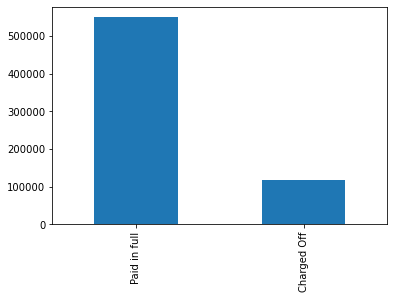

In [13]:
sba_train["Approve"].value_counts().rename({1: "Paid in full", 0: "Charged Off"}).plot(kind="bar")

The bar chart shows that Paid in full is the Majority Class.

In [14]:
test_majority_pred = pd.Series(1, index=sba_test.index)
confusion_matrix(sba_test["Approve"], test_majority_pred)

array([[     0,  38860],
       [     0, 182952]], dtype=int64)

In [15]:
print(classification_report(sba_test["Approve"], test_majority_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     38860
           1       0.82      1.00      0.90    182952

    accuracy                           0.82    221812
   macro avg       0.41      0.50      0.45    221812
weighted avg       0.68      0.82      0.75    221812



The accuracy for majority classifier is 0.82 which is same as the precision.

In [16]:
## Feature Engineering and Data Preprocessing using transformers

def approvalyear(mat):
    rows, cols = mat.shape
    assert cols == 1  # if we don"t have 2 columns, things are unexpected

    if hasattr(mat, "iloc"):
        return mat.iloc[:, 0].apply(lambda x: 1976 if x == "1976A" else int(x)).astype(int).to_frame()
    else:
        return  mat[:, 1].apply(lambda x: 1976 if x == "1976A" else int(x)).astype(int).reshape((rows, 1))

def backed_by_real_estate(mat):
    rows, cols = mat.shape
    assert cols == 1
    def encode(x):
        return 0 if x < 240 else 1

    if hasattr(mat, "iloc"):
        return mat.iloc[:, 0].apply(encode).to_frame()
    else:
        return mat[:, 0].apply(encode).reshape((rows, 1))


def clean_currency(mat):
    rows, cols = mat.shape
    assert cols == 1  # if we don"t have 2 columns, things are unexpected

    currency_cleaning = lambda x: int(float(x[1:].replace(",", "")))
    if hasattr(mat, "iloc"):
        return mat.iloc[:, 0].apply(currency_cleaning).astype(int).to_frame()
    else:
        return  mat[:, 1].apply(currency_cleaning).astype(int).reshape((rows, 1))

def SBA_approved_portion(mat):
    currency_cleaning = lambda x: int(float(x[1:].replace(",", "")))
    rows, cols = mat.shape
    assert cols == 2  # if we don"t have 2 columns, things are unexpected
    
    if hasattr(mat, "iloc"):
        mat.iloc[:, 0] = mat.iloc[:, 0].apply(currency_cleaning).astype(int)
        mat.iloc[:, 1] = mat.iloc[:, 1].apply(currency_cleaning).astype(int)
        res = mat.iloc[:, 0] / mat.iloc[:, 1]
        return res.to_frame()
    else:
        mat[:, 0] = mat[:, 0].apply(currency_cleaning).astype(int)
        mat[:, 1] = mat[:, 1].apply(currency_cleaning).astype(int)
        res = mat[:, 0] / mat[:, 1]
        return res.reshape((rows, 1))

def loan_active_during_recession(mat):
    rows, cols = mat.shape
    assert cols == 2  # if we don"t have 2 columns, things are unexpected
    
    if hasattr(mat, "iloc"):
        rec_date = pd.to_datetime(mat.iloc[:, 0]) + pd.to_timedelta(mat.iloc[:, 1]*30, unit="D")
        recession = pd.Series(0, index=mat.index)
        recession[(rec_date >= pd.to_datetime("2007-12-01")) & (rec_date <= pd.to_datetime("2009-06-30"))] = 1 
        return recession.to_frame()
    else:
        rec_date = pd.to_datetime(mat[:, 0]) + pd.to_timedelta(mat[:, 1]*30, unit="D")
        recession = pd.Series(0, index=mat.index)
        recession[(rec_date >= pd.to_datetime("2007-12-01")) & (rec_date <= pd.to_datetime("2009-06-30"))] = 1 

def franchise_classifier(mat):
    rows, cols = mat.shape
    assert cols == 1  # if we don"t have 2 columns, things are unexpected
    def classify(x):
        return 0  if x == 1 or x == 0 else 1

    if hasattr(mat, "iloc"):
        return mat.iloc[:, 0].apply(classify).to_frame()
    else:
        return  mat[:, 0].apply(classify).reshape((rows, 1))

def naics_classifier(mat):
    rows, cols = mat.shape
    assert cols == 1
    def encode(x):
        mapping = {
            "0": "0",
            "31": "31-33",
            "32": "31-33",
            "33": "31-33",
            "44": "44-45",
            "48": "48-49",
            "49": "48-49",
        }
        x = str(x)
        x = "0" if x[0] == "0" else x[:2]
        return mapping.get(x, x)

    if hasattr(mat, "iloc"):
        return mat.iloc[:, 0].apply(encode).to_frame()
    else:
        return mat[:, 0].apply(encode).reshape((rows, 1))
    
naics_pipeline = Pipeline(
    steps=[
        ("naics_class", FunctionTransformer(naics_classifier)), 
        ("encoding", OneHotEncoder(sparse=False, drop="first"))
        ]
)

disbrustment_gross_pipeline = Pipeline(
    steps=[
        ("clean_data", FunctionTransformer(clean_currency)), 
        ("scaler", StandardScaler())
        ]
)

## Initial Model

Splitting test data into train and tune set to play around with some models.

In [17]:
training_data, tuning_data = train_test_split(sba_train, test_size=0.1, random_state=42)

In [18]:
features = ["NAICS", "Term", "SBA_Appv", "GrAppv", "NewExist", "DisbursementDate"]
tf_pipe = ColumnTransformer(
    transformers=[
    ("naics", naics_pipeline, ["NAICS"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"])
    ],
    remainder="passthrough"
)
lm_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="none", max_iter=1000))

])

lm_pipe.fit(training_data[features], training_data["Approve"])
predicted = lm_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[   10 11542]
 [    6 55030]]
              precision    recall  f1-score   support

           0       0.62      0.00      0.00     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.73      0.50      0.45     66588
weighted avg       0.79      0.83      0.75     66588



Little improvement over Majority classifier.

In [19]:
features = ["State", "Term", "SBA_Appv", "GrAppv", "NewExist", "ApprovalFY", "DisbursementGross"]
tf_pipe = ColumnTransformer(
    transformers=[
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("approvalfy", FunctionTransformer(approvalyear), ["ApprovalFY"])
    ],
    remainder="passthrough"
)
lm_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="none", max_iter=1000))

])

lm_pipe.fit(training_data[features], training_data["Approve"])
predicted = lm_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[    0 11552]
 [    0 55036]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.41      0.50      0.45     66588
weighted avg       0.68      0.83      0.75     66588



Same results as Majority classifier.

In [20]:
features = ["FranchiseCode","ApprovalFY", "Term", "SBA_Appv", "GrAppv", "NewExist", "DisbursementDate"]
tf_pipe = ColumnTransformer(
    transformers=[
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("approvalfy", FunctionTransformer(approvalyear), ["ApprovalFY"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"])
    ],
    remainder="passthrough"
)
lm_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="none", max_iter=1000))

])

lm_pipe.fit(training_data[features], training_data["Approve"])
predicted = lm_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[    0 11552]
 [    0 55036]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.41      0.50      0.45     66588
weighted avg       0.68      0.83      0.75     66588



Same results as majority classifier.

In [21]:
features = ["NewExist", "Term", "LowDoc", "NoEmp", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "ApprovalFY", "NAICS", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("noemp", StandardScaler(), ["NoEmp"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("approvalfy", FunctionTransformer(approvalyear), ["ApprovalFY"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("naics", naics_pipeline, ["NAICS"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
lm_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="none", max_iter=1000))

])

lm_pipe.fit(training_data[features], training_data["Approve"])
predicted = lm_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[  152 11400]
 [   87 54949]]
              precision    recall  f1-score   support

           0       0.64      0.01      0.03     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.73      0.51      0.47     66588
weighted avg       0.79      0.83      0.75     66588



A few more true negative along with increased false negative.

##### Final Model

In [22]:

features = ["NewExist", "Term", "LowDoc", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
lm_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="none", max_iter=1000))

])

lm_pipe.fit(training_data[features], training_data["Approve"])
predicted = lm_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[  147 11405]
 [   72 54964]]
              precision    recall  f1-score   support

           0       0.67      0.01      0.02     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.75      0.51      0.47     66588
weighted avg       0.80      0.83      0.75     66588



Similarly to previous, Few false negatives along with some true positives. Lets test over the Test data.

In [23]:
# Testing final model on test data

predicted = lm_pipe.predict(sba_test[features])
lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(sba_test["Approve"], predicted).ravel()
print(confusion_matrix(sba_test["Approve"], predicted))
print(classification_report(sba_test["Approve"], predicted))

model_results = sba_test.copy()
model_results["Logistic"] = predicted

[[   536  38324]
 [   254 182698]]
              precision    recall  f1-score   support

           0       0.68      0.01      0.03     38860
           1       0.83      1.00      0.90    182952

    accuracy                           0.83    221812
   macro avg       0.75      0.51      0.47    221812
weighted avg       0.80      0.83      0.75    221812



Not much improvement over the accuracy. 

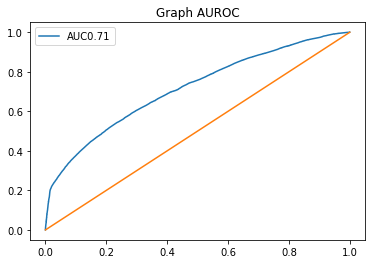

In [24]:
pred_proba = lm_pipe.predict_proba(sba_test[features])
prediction_AUC = pred_proba[:,1]

FPR, TPR, Threshold = roc_curve(sba_test["Approve"],prediction_AUC)
roc_auc = auc(FPR,TPR)

# Plot
plt.plot(FPR,TPR,label=f"AUC{round(roc_auc,2)}")
plt.plot([0,1],[0,1])
plt.title("Graph AUROC")
plt.legend()

## Lasso Regression

In [25]:
features = ["NAICS", "Term", "SBA_Appv", "GrAppv", "NewExist", "DisbursementDate"]
tf_pipe = ColumnTransformer(
    transformers=[
    ("naics", naics_pipeline, ["NAICS"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"])
    ]
)
lasso_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="l1", max_iter=1000, solver="saga"))

])

lasso_pipe.fit(training_data[features], training_data["Approve"])
predicted = lasso_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[   10 11542]
 [    6 55030]]
              precision    recall  f1-score   support

           0       0.62      0.00      0.00     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.73      0.50      0.45     66588
weighted avg       0.79      0.83      0.75     66588



In [26]:
features = ["NewExist", "Term", "LowDoc", "NoEmp", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "ApprovalFY", "NAICS", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("noemp", StandardScaler(), ["NoEmp"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("approvalfy", FunctionTransformer(approvalyear), ["ApprovalFY"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("naics", naics_pipeline, ["NAICS"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
lasso_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="l1", max_iter=1000, solver="saga"))

])

lasso_pipe.fit(training_data[features], training_data["Approve"])
predicted = lasso_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[   99 11453]
 [   48 54988]]
              precision    recall  f1-score   support

           0       0.67      0.01      0.02     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.75      0.50      0.46     66588
weighted avg       0.80      0.83      0.75     66588



Few true negatives and false negatives.

##### Final Model

In [27]:
features = ["NewExist", "Term", "LowDoc", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
lasso_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="l1", max_iter=1000, solver="saga"))

])

lasso_pipe.fit(training_data[features], training_data["Approve"])
predicted = lasso_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[  147 11405]
 [   72 54964]]
              precision    recall  f1-score   support

           0       0.67      0.01      0.02     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.75      0.51      0.47     66588
weighted avg       0.80      0.83      0.75     66588



Similarly to previous, Few false negatives along with some true positives. Lets test over the Test data.

In [28]:
# Testing final model on test data

predicted = lasso_pipe.predict(sba_test[features])
lasso_tn, lasso_fp, lasso_fn, lasso_tp = confusion_matrix(sba_test["Approve"], predicted).ravel()
print(confusion_matrix(sba_test["Approve"], predicted))
print(classification_report(sba_test["Approve"], predicted))

model_results["Lasso"] = predicted

[[   535  38325]
 [   254 182698]]
              precision    recall  f1-score   support

           0       0.68      0.01      0.03     38860
           1       0.83      1.00      0.90    182952

    accuracy                           0.83    221812
   macro avg       0.75      0.51      0.47    221812
weighted avg       0.80      0.83      0.75    221812



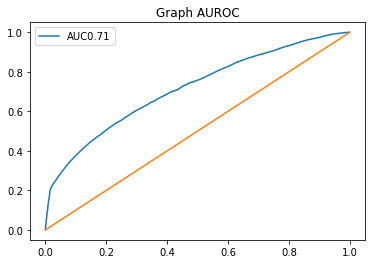

In [29]:
pred_proba =lasso_pipe.predict_proba(sba_test[features])
prediction_AUC = pred_proba[:,1]

FPR, TPR, Threshold = roc_curve(sba_test["Approve"],prediction_AUC)
roc_auc = auc(FPR,TPR)

# Plot
plt.plot(FPR,TPR,label=f"AUC{round(roc_auc,2)}")
plt.plot([0,1],[0,1])
plt.title("Graph AUROC")
plt.legend()

## ElasticNet

In [30]:
features = ["NAICS", "Term", "SBA_Appv", "GrAppv", "NewExist", "DisbursementDate"]
tf_pipe = ColumnTransformer(
    transformers=[
    ("naics", naics_pipeline, ["NAICS"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"])
    ]
)
elastic_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=0.5))

])

elastic_pipe.fit(training_data[features], training_data["Approve"])
predicted = elastic_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[   10 11542]
 [    6 55030]]
              precision    recall  f1-score   support

           0       0.62      0.00      0.00     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.73      0.50      0.45     66588
weighted avg       0.79      0.83      0.75     66588



In [31]:
features = ["NewExist", "Term", "LowDoc", "NoEmp", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "ApprovalFY", "NAICS", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("noemp", StandardScaler(), ["NoEmp"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("approvalfy", FunctionTransformer(approvalyear), ["ApprovalFY"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("naics", naics_pipeline, ["NAICS"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
elastic_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=0.5))

])

elastic_pipe.fit(training_data[features], training_data["Approve"])
predicted = elastic_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[   99 11453]
 [   48 54988]]
              precision    recall  f1-score   support

           0       0.67      0.01      0.02     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.75      0.50      0.46     66588
weighted avg       0.80      0.83      0.75     66588



Few true negatives along with false negatives.

##### Final Model

In [32]:
features = ["NewExist", "Term", "LowDoc", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
elastic_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", LogisticRegression(penalty="elasticnet", max_iter=1000, solver="saga", l1_ratio=0.5))

])

elastic_pipe.fit(training_data[features], training_data["Approve"])
predicted = elastic_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[  147 11405]
 [   72 54964]]
              precision    recall  f1-score   support

           0       0.67      0.01      0.02     11552
           1       0.83      1.00      0.91     55036

    accuracy                           0.83     66588
   macro avg       0.75      0.51      0.47     66588
weighted avg       0.80      0.83      0.75     66588



Similarly to previous, Few false negatives along with some true positives. Lets test over the Test data.

In [33]:
# Testing final model on test data

predicted = elastic_pipe.predict(sba_test[features])
elastic_tn, elastic_fp, elastic_fn, elastic_tp = confusion_matrix(sba_test["Approve"], predicted).ravel()
print(confusion_matrix(sba_test["Approve"], predicted))
print(classification_report(sba_test["Approve"], predicted))
model_results["Elastic"] = predicted

[[   535  38325]
 [   254 182698]]
              precision    recall  f1-score   support

           0       0.68      0.01      0.03     38860
           1       0.83      1.00      0.90    182952

    accuracy                           0.83    221812
   macro avg       0.75      0.51      0.47    221812
weighted avg       0.80      0.83      0.75    221812



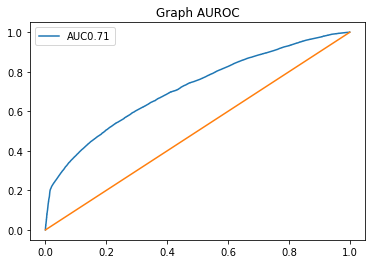

In [34]:
pred_proba =elastic_pipe.predict_proba(sba_test[features])
prediction_AUC = pred_proba[:,1]

FPR, TPR, Threshold = roc_curve(sba_test["Approve"],prediction_AUC)
roc_auc = auc(FPR,TPR)

# Plot
plt.plot(FPR,TPR,label=f"AUC{round(roc_auc,2)}")
plt.plot([0,1],[0,1])
plt.title("Graph AUROC")
plt.legend()

## Random Forest

In [35]:
features = ["NewExist", "Term", "LowDoc", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
random_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", RandomForestClassifier(random_state=101, n_estimators=150))

])

random_pipe.fit(training_data[features], training_data["Approve"])
predicted = random_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[ 2989  8563]
 [ 4649 50387]]
              precision    recall  f1-score   support

           0       0.39      0.26      0.31     11552
           1       0.85      0.92      0.88     55036

    accuracy                           0.80     66588
   macro avg       0.62      0.59      0.60     66588
weighted avg       0.77      0.80      0.78     66588



Higher number of false negatives for this classifier.

##### Final Model

In [36]:
features = ["NewExist", "Term", "LowDoc", "DisbursementGross", "SBA_Appv", "GrAppv", "DisbursementDate", "FranchiseCode", "State"]

tf_pipe = ColumnTransformer(
    transformers=[
    ("new", OneHotEncoder(sparse=False, drop="first"), ["NewExist"]),
    ("real_estate", FunctionTransformer(backed_by_real_estate), ["Term"]),
    ("lowdoc", OneHotEncoder(sparse=False, drop="first"), ["LowDoc"]),
    ("disbursmentgross", disbrustment_gross_pipeline, ["DisbursementGross"]),
    ("sba_portion", FunctionTransformer(SBA_approved_portion), ["SBA_Appv", "GrAppv"]),
    ("recession", FunctionTransformer(loan_active_during_recession), ["DisbursementDate", "Term"]),
    ("franchise", FunctionTransformer(franchise_classifier), ["FranchiseCode"]),
    ("state", OneHotEncoder(sparse=False), ["State"]),
    ]
)
random_pipe = Pipeline([
    ("columns", tf_pipe),
    ("model", RandomForestClassifier(random_state=101))

])

random_pipe.fit(training_data[features], training_data["Approve"])
predicted = random_pipe.predict(tuning_data[features])
print(confusion_matrix(tuning_data["Approve"], predicted))
print(classification_report(tuning_data["Approve"], predicted))

[[ 2983  8569]
 [ 4663 50373]]
              precision    recall  f1-score   support

           0       0.39      0.26      0.31     11552
           1       0.85      0.92      0.88     55036

    accuracy                           0.80     66588
   macro avg       0.62      0.59      0.60     66588
weighted avg       0.77      0.80      0.78     66588



Similar to the previous model. Lets test over the Test data.

In [39]:
predicted = random_pipe.predict(sba_test[features])
rc_tn, rc_fp, rc_fn, rc_tp = confusion_matrix(sba_test["Approve"], predicted).ravel()
print(confusion_matrix(sba_test["Approve"], predicted))
print(classification_report(sba_test["Approve"], predicted))
model_results["Random Forest"] = predicted

[[  9887  28973]
 [ 15153 167799]]
              precision    recall  f1-score   support

           0       0.39      0.25      0.31     38860
           1       0.85      0.92      0.88    182952

    accuracy                           0.80    221812
   macro avg       0.62      0.59      0.60    221812
weighted avg       0.77      0.80      0.78    221812



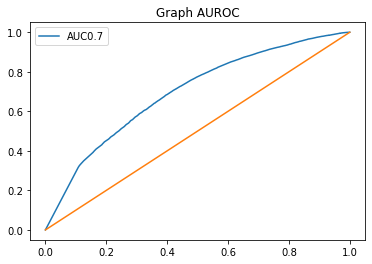

In [40]:
pred_proba =random_pipe.predict_proba(sba_test[features])
prediction_AUC = pred_proba[:,1]

FPR, TPR, Threshold = roc_curve(sba_test["Approve"],prediction_AUC)
roc_auc = auc(FPR,TPR)

# Plot
plt.plot(FPR,TPR,label=f"AUC{round(roc_auc,2)}")
plt.plot([0,1],[0,1])
plt.title("Graph AUROC")
plt.legend()

## Final Summary and Reflection

In [41]:
summary = [
            ["Logistic regrssion", lr_tn, lr_fp, lr_fn, lr_tp],
            ["Lasso", lasso_fn, lasso_fp, lasso_fn, lasso_tp],
            ["Elastic net", elastic_tn, elastic_fp, elastic_fn, elastic_tp],
            ["Random forest", rc_tn, rc_fp, rc_fn, rc_tp]
            ]
df = pd.DataFrame(
    summary, 
    columns=["Model Type", "True Negative", "False Positive", "False Negative", "True Positive"]
).set_index("Model Type")

<AxesSubplot:xlabel='Model Type'>

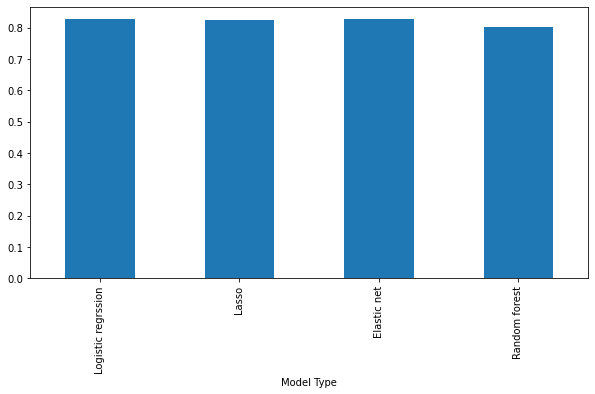

In [42]:
df["Accuracy"] = (df["True Positive"] + df["True Negative"]) / (df["True Positive"] + df["True Negative"] + df["False Positive"] + df["False Negative"])
df["Precision"] = df["True Positive"] / (df["True Positive"] + df["False Positive"])
df["Recall"] = df["True Positive"] / (df["True Positive"] + df["False Negative"])
df["Specificity"] = df["True Negative"] / (df["True Negative"] + df["False Positive"])
df["False Negative Rate"] = df["False Negative"] / (df["False Negative"] + df["True Negative"])
df["Cost"] = df["False Negative"] + df["False Positive"]*5

df["Accuracy"].plot(kind="bar", figsize=(10,5))

Accuracy is almost same across the different models.

<AxesSubplot:xlabel='Model Type'>

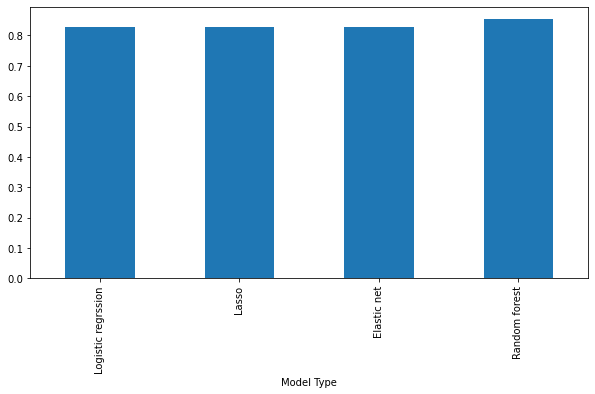

In [43]:
df["Precision"].plot(kind="bar", figsize=(10,5))

Precision is almost same across the different models.

<AxesSubplot:xlabel='Model Type'>

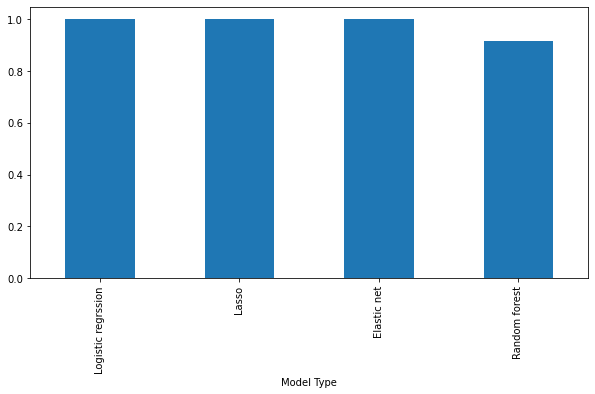

In [44]:
df["Recall"].plot(kind="bar", figsize=(10,5))

Recall for the random forest classifier slightly lower.

<AxesSubplot:xlabel='Model Type'>

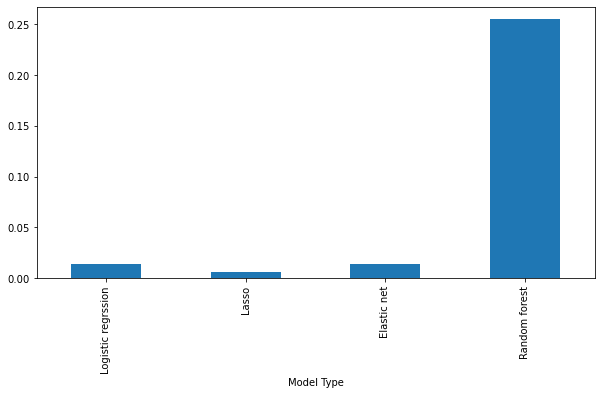

In [45]:
df["Specificity"].plot(kind="bar", figsize=(10,5))

Specificity of Random forest it the highest as it predicted more defaulted loans.

<AxesSubplot:xlabel='Model Type'>

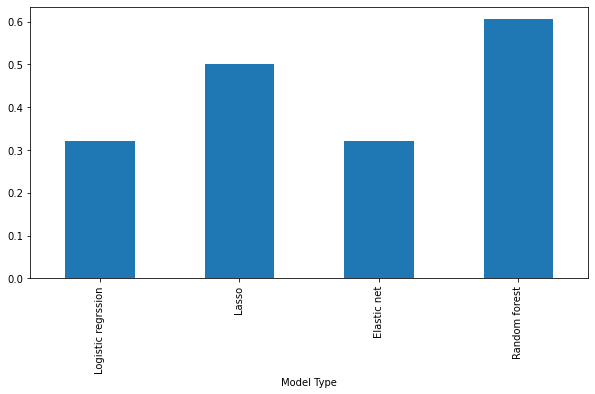

In [46]:
df["False Negative Rate"].plot(kind="bar", figsize=(10,5))

False Negative rate is highest for the Random forest followed by Lasso model.

<AxesSubplot:xlabel='Model Type'>

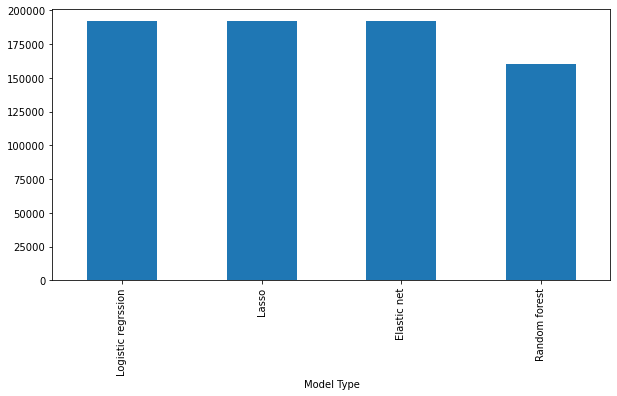

In [47]:
df["Cost"].plot(kind="bar", figsize=(10,5))

The Random forest model has the lowest cost among the all.

In [48]:
new_business = model_results[model_results["NewExist"] == 2.0]
existing_business = model_results[model_results["NewExist"] == 1.0]
summary = []
for model in ["Logistic", "Lasso", "Elastic", "Random Forest"]:
    tn, fp, fn, tp = confusion_matrix(new_business["Approve"], new_business[model]).ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    summary.append(["New", model, fnr, fpr, precision])

    tn, fp, fn, tp = confusion_matrix(existing_business["Approve"], existing_business[model]).ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    summary.append(["Existing", model, fnr, fpr, precision])



df = pd.DataFrame(
    summary, 
    columns=["Business Type", "Model Type", "FNR", "FPR", "Precision"]
)

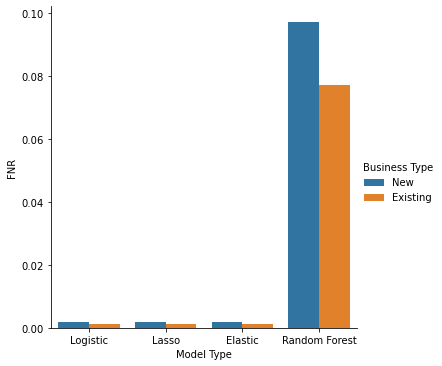

In [49]:
sns.catplot(x="Model Type", y="FNR", hue="Business Type", data=df, kind="bar")

False Negative rate is a bit higher for  new business.

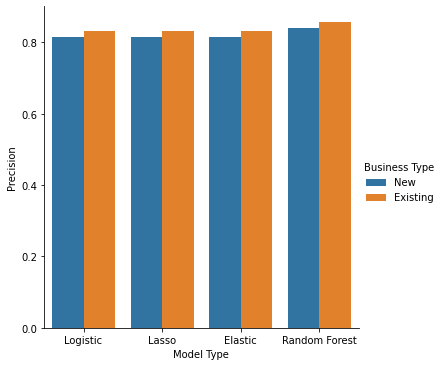

In [50]:
sns.catplot(x="Model Type", y="Precision", hue="Business Type", data=df, kind="bar")

Precision is higher for Existing business.

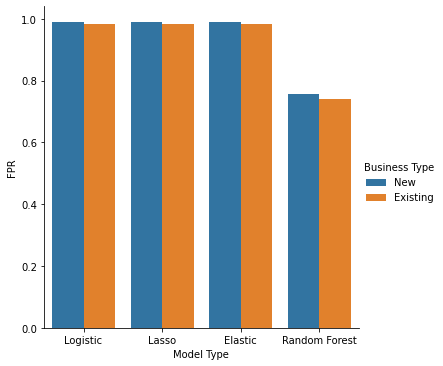

In [51]:
sns.catplot(x="Model Type", y="FPR", hue="Business Type", data=df, kind="bar")

False Positive Rate is higher for New Business.

Things I learned about the data.
* Exploratory analysis of the data set.
* Work with data to find important feature for classification
* Preprocessing data such as cleaning null values, transforming categorical data using Dummy encoding, Standardizing data 
* Combining multiple features to generate a newer one that might have more impact on the model performances
* Working with real world data is challenging. Sample data that we usually have balanced classes and performs pretty well in a simple model. But it might not be the same case for the real data. Classes might be imbalanced
* Results might be what you expected while working with the real data. They require more Data analysis, feature engineering and modeling for better performance.
* Not all features are important for prediction. Some features have higher impact on the model decision over other. Thus, the Feature engineering process is one the most significant step.
* Correlated variables may be bad for the model. 

Things I learned about the models and performance.
* Confusion matrix helps to quantify the model performance.
* Accuracy is not the only measure of the model performance. Different scenarios require various metrics such as False negative rate or False Positive rate to be improved. 
* I tried using different algorithm for same set of features. Model inherently cannot be classified as good or bad. I assumed Random forest classifier to perform much better than Logistic Regression. But the improvement was not that significant. The performance of the model highly depends on the features being used and the feature engineering process.
* Regularization discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.